In [26]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import execute, transpile
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## 1. Algorithm

In [27]:
w = 22 % 8
print(w)

6


In [28]:
wb = bin(w)[2:] 

print(wb)

110


In [29]:
x= len(wb)

print('number of qubits: ', x)

number of qubits:  3


In [30]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [31]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [32]:
qc = QuantumCircuit(3)
#change in phase
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)

qc.x(0)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

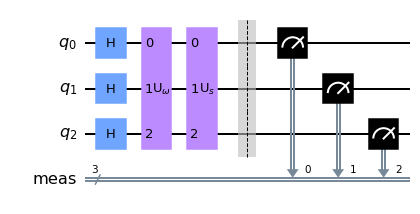

In [33]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw(output='mpl')

In [34]:
import math as m

times= round(m.sqrt(2**x))
print(times)

3


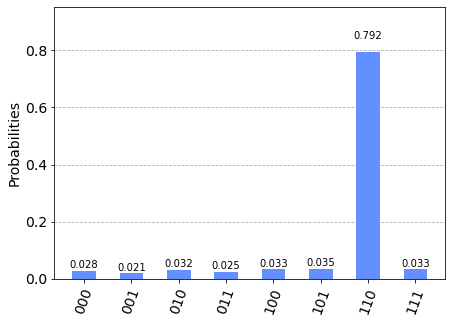

In [74]:
backend = Aer.get_backend("qasm_simulator")
shots=1024
result = execute(grover_circuit, backend, shots=shots).result()
counts_sim = result.get_counts(grover_circuit)
plot_histogram(counts_sim)

In [73]:
grover_circuit.depth()

4

## 2. Simulation with noise

In [55]:
%qiskit_backend_overview

In [208]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

# Define backend
backend_device = my_provider_ibmq.get_backend('ibmq_manila')

# See backend information
backend_device

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In these devices the connections between the qubits are not arbitrary. 

Trying to connect qubits that are not directly linked in the devices arquitecture, increases the circuit size, and consequently, increase the probability of errors.

In [190]:
coupling_map = backend_device.configuration().coupling_map

In [191]:
from qiskit.providers.aer.noise import NoiseModel

In [192]:
# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(backend_device)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'sx', 'cx', 'measure', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('sx', [5]), ('sx', [6]), ('sx', [7]), ('sx', [8]), ('sx', [9]), ('sx', [10]), ('sx', [11]), ('sx', [12]), ('sx', [13]), ('sx', [14]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('x', [5]), ('x', [6]), ('x', [7]), ('x', [8]), ('x', [9]), ('x', [10]), ('x', [11]), ('x', [12]), ('x', [13]), ('x', [14]), ('cx', [14, 0]), ('cx', [0, 14]), ('cx', [14, 13]), ('cx', [13, 14]), ('cx', [6, 8]), ('cx', [8, 6]), ('cx', [5, 9]), ('cx', [9, 5]), ('cx', [4, 10]), ('cx', [10, 4]), ('cx', [11, 3]), ('cx', [3, 11

In [193]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'rz', 'sx', 'x']


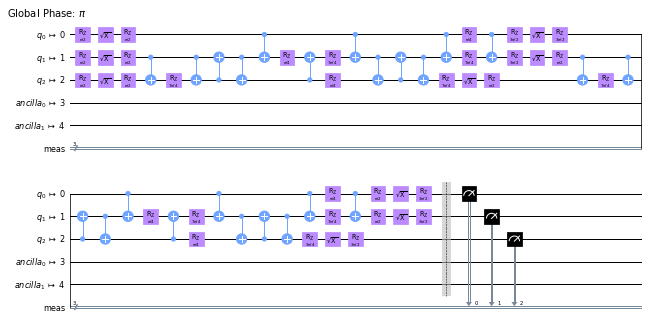

In [314]:
from qiskit.compiler import transpile

qc_t_real = transpile(grover_circuit, backend=backend_device)

#qc_t_real.draw(output='mpl', scale=0.5)

In [229]:
grover_circuit.depth()

4

In [230]:
qc_t_real.depth()

42

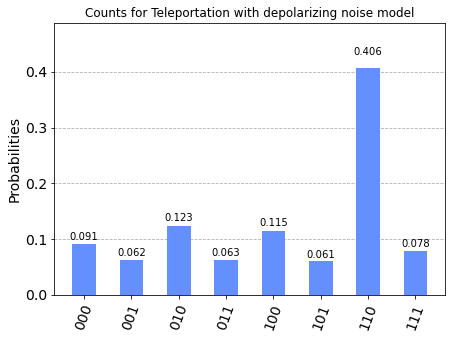

In [307]:
# Execute noisy simulation and get counts
result_noise = execute(qc_t_real, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_t_real)
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

### Level 1

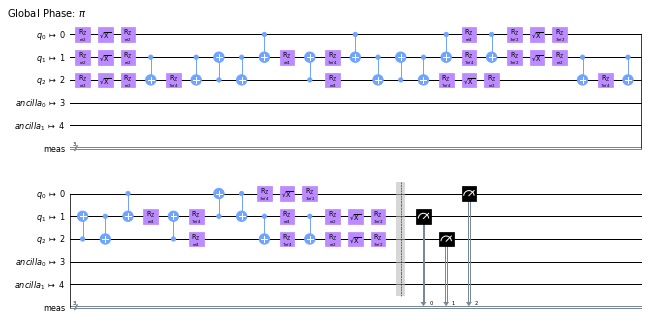

In [313]:
qc_optimized = transpile(grover_circuit, backend=backend_device, optimization_level=1)
#qc_optimized.draw(output='mpl', scale=0.5)

In [305]:
qc_optimized.depth()

40

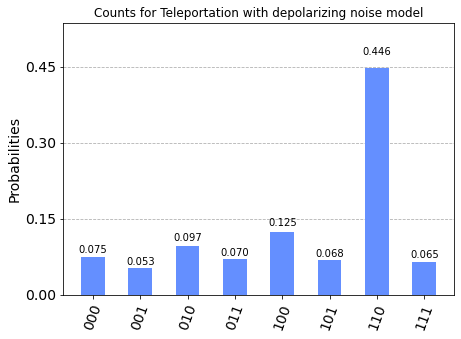

In [306]:
# Execute noisy simulation and get counts
result_noise = execute(qc_optimized, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_optimized)
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

### Level 2

In [280]:
qc_optimized = transpile(grover_circuit, backend=backend_device, optimization_level=2)
#qc_optimized.draw(output='mpl', scale=0.5)

In [281]:
qc_optimized.depth()

45

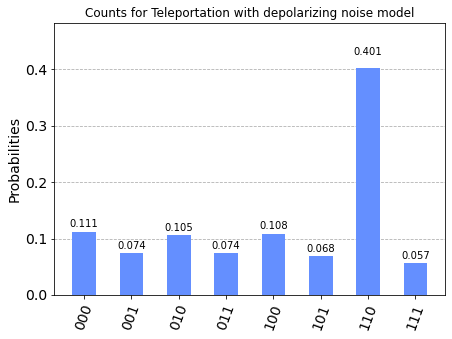

In [284]:
# Execute noisy simulation and get counts
result_noise = execute(qc_optimized, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_optimized)
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

### Level 3

In [285]:
qc_optimized = transpile(grover_circuit, backend=backend_device, optimization_level=3)
#qc_optimized.draw(output='mpl', scale=0.5)

In [286]:
qc_optimized.depth()

55

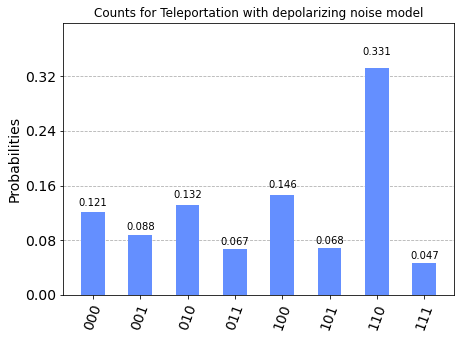

In [287]:
# Execute noisy simulation and get counts
result_noise = execute(qc_optimized, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_optimized)
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

Optimization level 1 seems to be the best one in this machine

## 3. Run in real machine

In [37]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2021-06-06 14:58:33,333: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [38]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [39]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 12             Pending Jobs: 17             Pending Jobs: 9
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      163.8          Avg. T1:      80.3           Avg. T1:      75.9
Avg. T2:      68.2           Avg. T2:      71.2           Avg. T2:      75.6



ibmq_lima                   ibmq_santiago                ibmq_athens
---------                   -------------                -----------
Num. Qubits:  5             Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 0             Pending Jobs: 8              Pending Jobs: 2
Least busy:   True          Least busy:   False          Least busy:   False
Operational:  True          Operational: 

In [308]:
print("Running on: ", backend_device)

Running on:  ibmq_manila


In [309]:
# See backend information
backend_device

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In [310]:
backend_monitor(backend_device)


ibmq_manila
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 11
    backend_version: 1.0.1
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    allow_object_storage: True
    description: 5 qubit device
    credits_required: True
    rep_times: [0.001]
    multi_meas_enabled: True
    meas_map: [[0, 1, 2, 3, 4]]
    memory: True
    hamiltonian: {'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation

In [311]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [330]:
job_r = execute(grover_circuit, backend_device, shots=1024)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bd0c00b454d04decaa76de


In [331]:
job_get=backend_device.retrieve_job("60bd0c00b454d04decaa76de")

result_r = job_get.result()
counts_run = result_r.get_counts(grover_circuit)

In [312]:
job_r = execute(qc_optimized, backend_device, shots=1024)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bcf001917aa094019b7bc1


In [316]:
job_get=backend_device.retrieve_job("60bcf001917aa094019b7bc1")

result_r = job_get.result()
counts_opt = result_r.get_counts(grover_circuit)

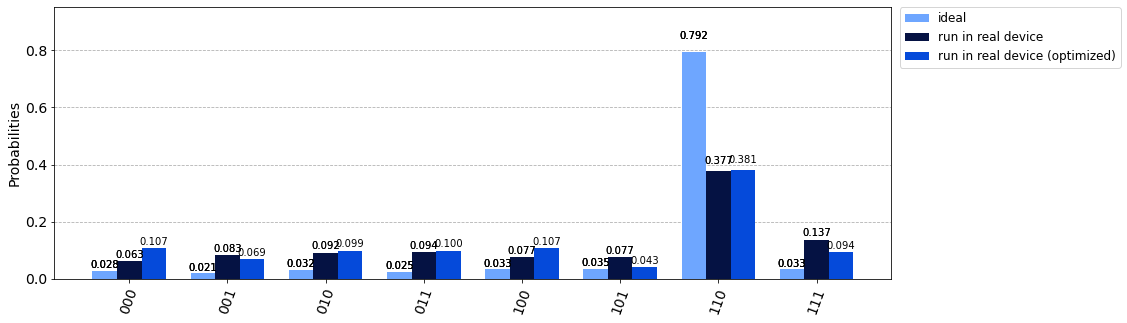

In [332]:
legend = ['ideal', 'run in real device', 'run in real device (optimized)']
color = ['#6ea6ff','#051243','#054ada']
plot_histogram([counts_sim, counts_run, counts_opt ], legend=legend, color=color, figsize=(15,5))

## 4. Ignis

In [315]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [318]:
# Generate the calibration circuits
qr = QuantumRegister(x)

# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [319]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [320]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bcf3fbb454d0dd7caa75ae


In [321]:
job_get=backend_device.retrieve_job("60bcf3fbb454d0dd7caa75ae")

cal_results = job_get.result()

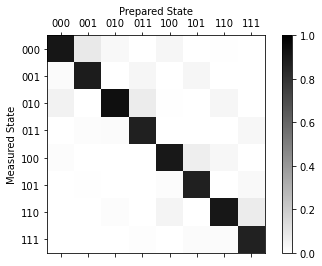

In [322]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [323]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.894531


In [324]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

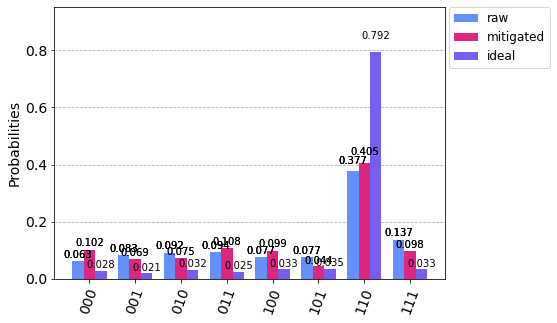

In [333]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])